# <center>**Quantum Random Number Generator (W State)**</center>

By using the key components of quantum computing, superposition and entanglement, we can create a random number generator (RNG) - one of the simplist applications of quantum computing. The benefit for using quantum computers to generate random numbers is that they are 'true' probabilistic calculations, not deterministic 'pseudo' RNGs, which use algorithms to produce their results. However, there are exceptions, like [random.org](https://www.random.org/) which uses external factors like weather conditions to create random outputs.

To create this RNG, we need to create and execute a quanutm circuit on real quantum hardware. The most accessible way to do this is through IBM Quantum's Qiskit (quantum information science kit) and the IBM Quantum Platform, where we get limited but free access to quantum hardware over the cloud.

Qiskit is the most widely used software development kit (SDK) for quantum computation, and the general workflow of a quantum program ([Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns)) is as follows:

**1.** Map problem to quantum circuits and operators <br>
**2.** Optimise for target hardware <br>
**3.** Execute on target hardware <br>
**4.** Post-process results <br>

But before that, we need to import some required modules:

## **Imports**

In [3]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_circuit_layout, plot_histogram
import matplotlib.pyplot as plt
import numpy as np

## **1. Map problem to quantum circuits and operators**

To map our RNG, we need to use gates (equivalent to logic gates of classical computers, though of very different nature) and qubits. The below code creates a special kind of circuit, known as the W state which puts the three qubits ($q_0$, $q_1$, $q_2$) into the state:

<center>$|W\rangle = \frac{1}{\sqrt{3}} \left( |001\rangle + |010\rangle + |100\rangle \right)$</center>

Where each qubit has a 1 in 3 chance of being in the $|1\rangle$ state with the other two in the $|0\rangle$ state. This is equivalent of a RNG choosing from the numbers 1, 2, or 3.

Below is the Qiskit code to create this state, the [Bloch sphere](https://medium.com/quantum-untangled/quantum-states-and-the-bloch-sphere-9f3c0c445ea3) for each qubit, and the related circuit diagram. See [here](https://docs.quantum.ibm.com/guides/construct-circuits) to learn more about the symbols and gates used in this and all other circuits.

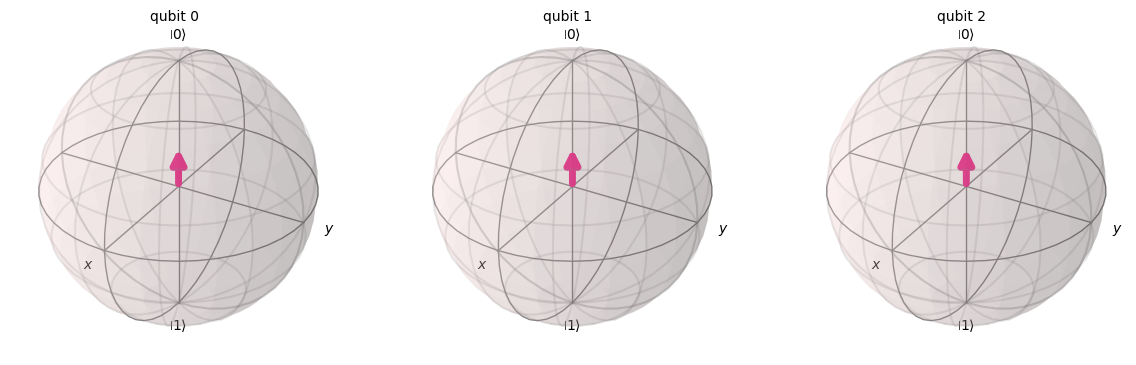

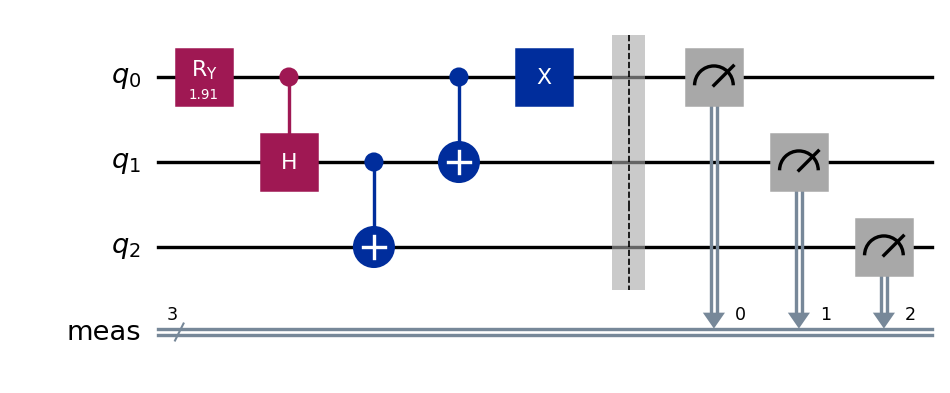

In [4]:
# initialise a quantum circuit with 3 qubits
qc = QuantumCircuit(3)

# apply gates (operators) to qubits to entangle and put into superposition
qc.ry(np.arccos(-1/3), 0)
qc.ch(0, 1)        
qc.cx(1, 2)
qc.cx(0, 1)
qc.x(0)

# display the Bloch spheres
state = Statevector(qc)
display(plot_bloch_multivector(state))

# measure the state of all qubits
qc.measure_all()

# display the circuit diagram
fig, ax = plt.subplots(figsize=(12, 8))
qc.draw('mpl', ax=ax)

## **2. Optimise for target hardware**

Optimising, or more generally, [transpiling](https://docs.quantum.ibm.com/api/qiskit/transpiler) the circuit involves 6 stages:

**Init Stage:** this stage isn't needed for our circuit, its main responsibility is translating gates that act on more than two qubits into gates that act only on one or two.

**Layout Stage:** maps the positions of virtual qubits in our abstract circuit onto the positions of physical qubits on the hardware. This is important to do well, as if they are poorly mapped, the circuit will need to implement more SWAP gates to get qubits closer together when needed. The more SWAP gates there are (the more gates there are in general) the more likely it is that errors will occur.

**Routing Stage:** this accompanies the layout stage, and is responsible for finding the layout with the fewest number of SWAP gates required.

**Translation Stage:** a crucial stage that translates the gates used in our abstract circuit into gates that are usable by the backend (called the basis gates). Since IBM machines use superconducting transmon qubits that can only be influenced by precise microwave pulses, more complex gates aren't possible - so the gates have to be decomposed into simpler gates that can be converted into microwave pulses. These native gates are part of the instruction set architecture (ISA: all the related hardware for a sinlge backend).

**Optimisation Stage:** this stage involves using routines to limit the depth (critical path: maximum number of operations on a single qubit) and number of gates in a transpiled circuit. This is to reduce the chance of error and reduce QPU runtime.

**Scheduling Stage:** doesn't run by default (like init stage), but if called upon, addresses the idle time of qubits. As the longer a qubit stays idle, the more likely it is to decohere. See the above circuit diagram, $q_0$ has a period of idle time between the controlled Hadamard gate and controlled NOT gate - though small compared to more complex circuits. To prevent decoherence, delay instructions can be implemented, as well as [dynamical decoupling](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.DynamicalDecoupling) methods.

The code below retrieves the least busy QPU (one with the fewest pending jobs) and transpiles the circuit in accordance to its ISA. This transpilation is the default, bare minimum of what is required, larger circuits will benefit from more fleshed out methods (such as using user-defined pass managers).

The cells below display the results of the transpilation and how the final circuit is perceived by the hardware. Note: 'ancillas' can be thought of as place-holder qubits with little impact on the actual circuit (they are the unused qubits of the backend).

In [5]:
# find suitable backend (QPU) to use
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

# transpile circuit
qc_transpiled = transpile(qc, backend)

QPU: ibm_brisbane
['ecr', 'id', 'rz', 'sx', 'x']


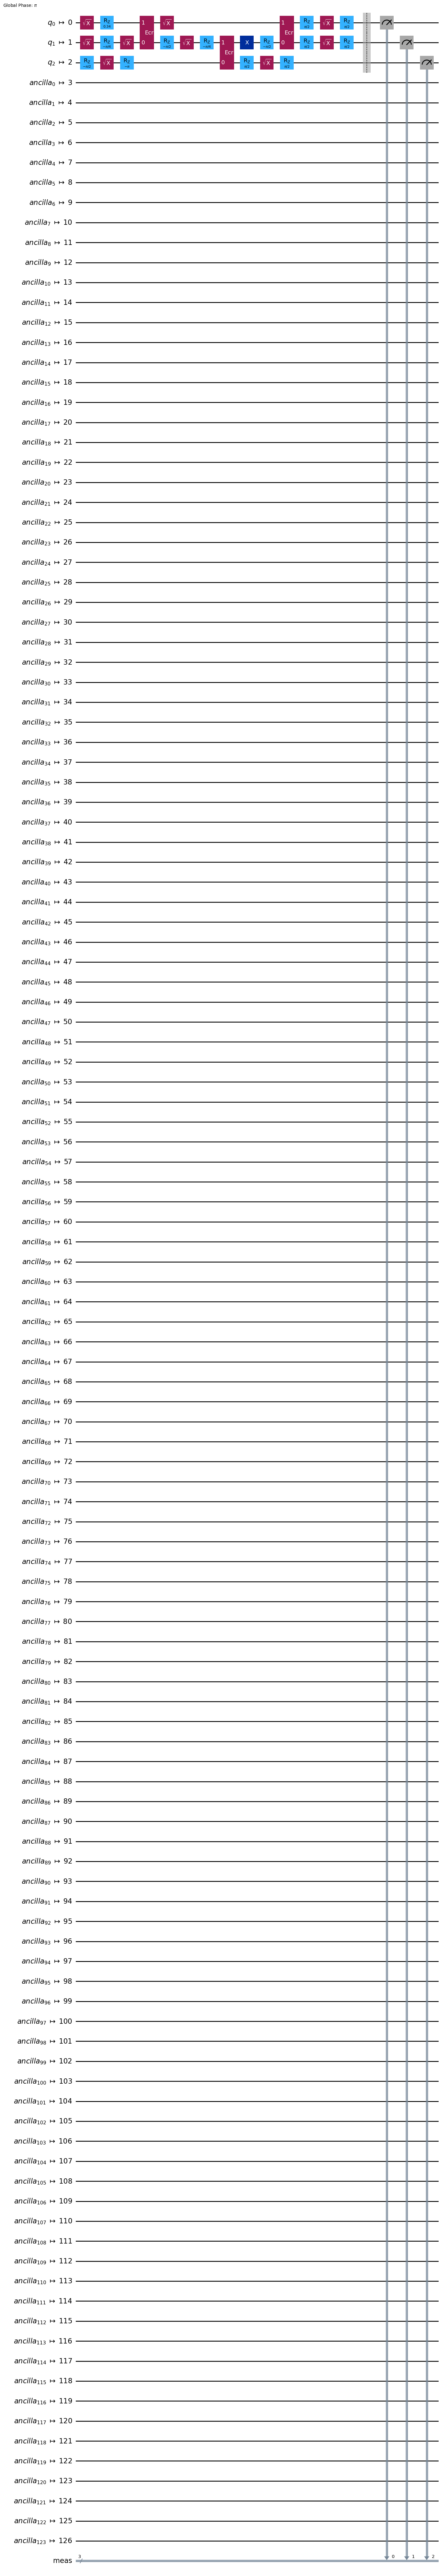

In [6]:
# show backend and basis gates and transpiled circuit diagram
print(f'QPU: {backend.name}')
print(backend.basis_gates)
display(qc_transpiled.draw('mpl'))

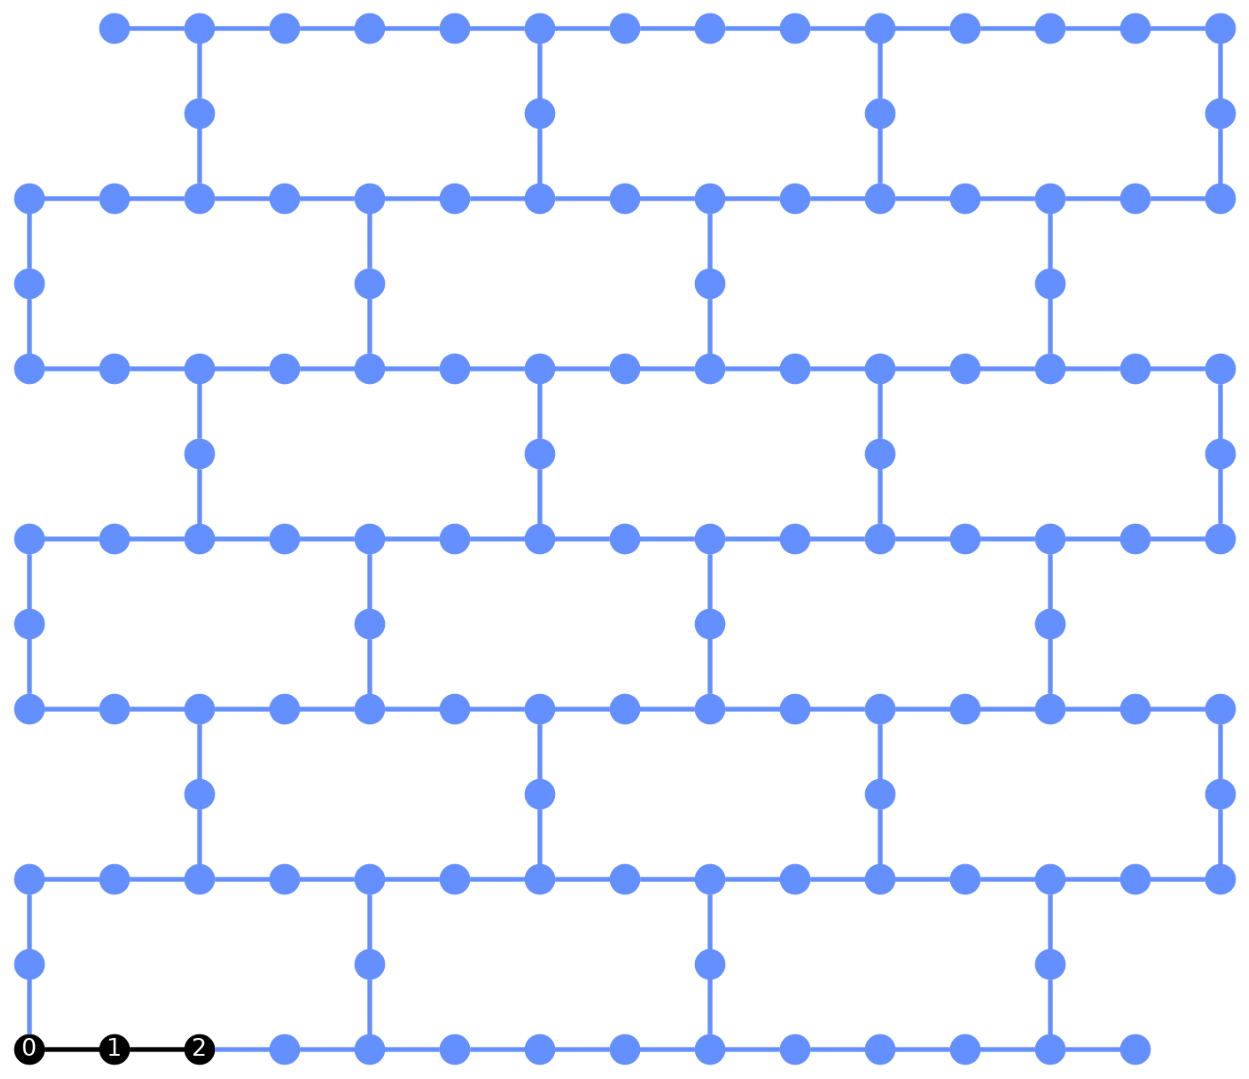

In [7]:
# qubit map of backend with location of circuit qubits
plot_circuit_layout(qc_transpiled, backend=backend)

## **3. Execute on target hardware**

Stage 3 is the running of the program. For this ciruit, I use the Sampler [primitive](https://docs.quantum.ibm.com/guides/get-started-with-primitives) which calculates probabilities of bitstrings from quantum circuits - which is what we're after. Currently, the shots are set to 1024, meaning the circuit will be executed 1024 times by the QPU.

In [4]:
# execute the circuit
sampler = Sampler(mode=backend)
job = sampler.run([qc_transpiled], shots=1024)

## **4. Post-process results**

The final stage of the Qiskit pattern is to extract the desired data from the job (executed circuit) after it is completed. To move onto this step, we may have to wait a few hours or days (depending on the queue and the size of our job, as shorter, optimised jobs get prioritised).

For the RNG, we want to extract the number of times each bitstring was returned, an then plot those results to see how accurately the RNG has worked. For the code below, I plot 2 instances of the circuit's results. Which, for an ideal system would return a faily even count of the bitstrings (state vectors) $|001\rangle$, $|010\rangle$ and $|100\rangle$:

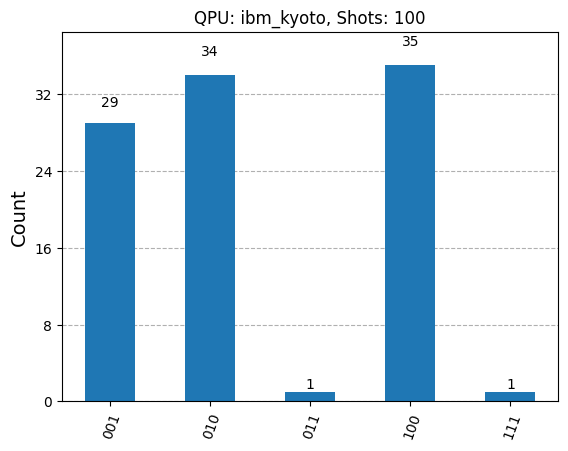

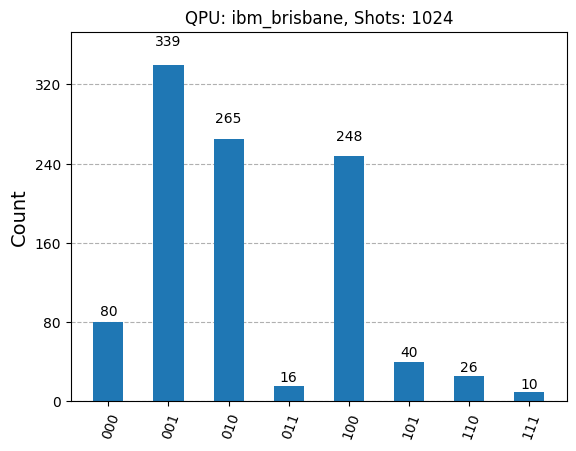

In [17]:
jobs = [('cty9kmeyfnpg008wc10g','ibm_kyoto', 100), ('ctz3nwzzzp40008h2jjg', 'ibm_brisbane', 1024)]

for job in jobs:
    
    job_instance = service.job(job[0])
    
    result = job_instance.result()
    counts = result[0].data.meas.get_counts()

    title = f"QPU: {job[1]}, Shots: {job[2]}"
    hist = plot_histogram(counts, title=title)
    display(hist)
    # hist.savefig(f'{job[2]}.png')

The first job returns a graph that looks faily decent, except for the rogue bitstrings which are by-products of noise and error. This error and noise is currently one of the biggest challenges of making utility-scale quantum computers, as even in a ciruit as simple as this one, errors still affect results.

Additionally, the second job's results are even worse - the distribution of expected results isn't even (though this could well be due to chance) but more importantly, there's even more of an impact from errors. This is likley due to the circuit being run over 1000 times - where the state of the qubits deteriorates and there is more time for external noise to influence results.

Due to these errors, it is possible for you to run a circuit and get a completely wrong result. Going off the second job - there is a 17% chance of getting a rogue bitstring! This is why jobs are often run multiple times, to suppress the incidence of errors and to show the likley results. Though even then, this method doesn't eliminate the possibility of getting a prevailing error result. This is why techniques such as error mitigation and correction are at the top of the priority list for quantum software and hardware engineers. We need accurate results to use quantum computers for more complex tasks - like weather prediction.

## **Comparison to classical RNG**

At this point in time, no one is going to run a quanutm circuit to retrieve a random number, because of the error rate, but more crucially, because of the amount of effort.

The below code shows how you can run an equivalent program to return a random number (1, 2, or 3) in Python. Although it is pseudorandom (produced by deterministic algorithms) it still provides a very reliably random number, and in a fraction of the time and effort it takes a Qiskit program to do the same thing.

So, although there is no quantum advantage for RNGs (just yet) and creating this circuit provided no practical value, there is still one way where quantum computers beat classical computers for this. And that is the amount of gates needed to produce a random number. The above transpiled circuit only requires 29 basis gates to create and measure a random number from 1 to 3. Whereas for high-quality classical RNGs, the number of fundamental logic gates required is much higher. However, the number of gates to run the microwave pulses is even higher than that - so there is still little comparision.

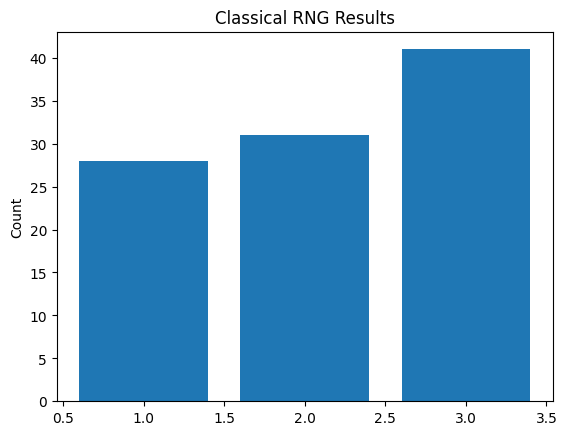

In [8]:
import random
nums = [1, 2, 3]
counts = [0, 0, 0]

for _ in range(100):
    value = random.randint(1, 3)
    counts[value - 1] += 1

import matplotlib.pyplot as plt
plt.bar(nums, counts)
plt.title('Classical RNG Results')
plt.ylabel('Count')
# plt.savefig('cl.png')
plt.show();